# LightDark Demo

In [1]:
importall POMDPs
using POMDPToolbox
using Distributions
using Parameters
using Plots
using StaticArrays

# Problem Definition

In [2]:
@with_kw struct SimpleLightDark <: POMDPs.POMDP{Int,Int,Float64}
    discount::Float64       = 0.95
    correct_r::Float64      = 100.0
    incorrect_r::Float64    = -100.0
    light_loc::Int          = 10
    radius::Int             = 60
end
discount(p::SimpleLightDark) = p.discount
isterminal(p::SimpleLightDark, s::Number) = !(s in -p.radius:p.radius)

const ACTIONS = [-10, -1, 0, 1, 10]
actions(p::SimpleLightDark) = ACTIONS
n_actions(p::SimpleLightDark) = length(actions(p))
const ACTION_INDS = Dict(a=>i for (i,a) in enumerate(actions(SimpleLightDark())))
action_index(p::SimpleLightDark, a::Int) = ACTION_INDS[a]

states(p::SimpleLightDark) = -p.radius:p.radius + 1
n_states(p::SimpleLightDark) = length(states(p))
state_index(p::SimpleLightDark, s::Int) = s+p.radius+1

function transition(p::SimpleLightDark, s::Int, a::Int) 
    if a == 0
        return SparseCat(SVector(p.radius+1), SVector(1.0))
    else
        return SparseCat(SVector(clamp(s+a, -p.radius, p.radius)), SVector(1.0))
    end
end

observation(p::SimpleLightDark, sp) = Normal(sp, abs(sp - p.light_loc) + 0.0001)

function reward(p::SimpleLightDark, s, a)
    if a == 0
        return s == 0 ? p.correct_r : p.incorrect_r
    else
        return -1.0
    end
end

function initial_state_distribution(p::SimpleLightDark)
    ps = ones(2*div(p.radius,2)+1)
    ps /= length(ps)
    return SparseCat(div(-p.radius,2):div(p.radius,2), ps)
end;

# Visualization

In [3]:
using Plots

function plothist(pomdp, hist, heading="LightDark")
    tmax = 80
    smin = -10
    smax = 20
    vsh = collect(filter(s->!isterminal(pomdp,s), state_hist(hist)[1:end-1]))
    bh = belief_hist(hist)

    pts = Int[]
    pss = Int[]
    pws = Float64[]

    for t in 0:length(bh)-1
        b = bh[t+1]
        for s in smin:smax
            w = 10.0*sqrt(pdf(b, s))
            if 0.0<w<1.0
                w = 1.0
            end
            push!(pts, t)
            push!(pss, s)
            push!(pws, w)
        end
    end

    T = linspace(0.0, tmax)
    S = linspace(-1.0, 21.0)
    inv_grays = cgrad([RGB(1.0, 1.0, 1.0),RGB(0.0,0.0,0.0)])
    p = contour(T, S, (t,s)->abs(s-pomdp.light_loc),
            bg_inside=:black,
            fill=true,
            xlim=(0, tmax),
            ylim=(smin, smax),
            color=inv_grays,
            xlabel="Time",
            ylabel="State",
            cbar=false,
            legend=:topright,
            title=@sprintf("%s (Reward: %8.2f)", heading, discounted_reward(hist))
           )
    plot!(p, [0, tmax], [0, 0], linewidth=1, color="green", label="Goal", line=:dash)
    scatter!(p, pts, pss, color="lightblue", label="Belief Particles", markersize=pws, marker=stroke(0.1, 0.3))
    plot!(p, 0:length(vsh)-1, vsh, linewidth=3, color="orangered", label="Trajectory")
    return p
end;

# Create Solver

In [7]:
using ParticleFilters
rng = MersenneTwister(7)

p = SimpleLightDark()
pf = SIRParticleFilter(p, 10000, rng=rng)

using POMCPOW
srand(rng, 7)
max_depth = 20
max_time=0.01
sol = POMCPOWSolver(tree_queries=10_000_000,
                       criterion=MaxUCB(90.0),
                       max_depth=max_depth,
                       max_time=max_time,
                       enable_action_pw=false,
                       k_observation=5.0,
                       alpha_observation=1/15.0,
                       # estimate_value=FOValue(ro),
                       estimate_value=FORollout(RandomSolver()),
                       check_repeat_obs=false,
                       tree_in_info=true,
                       rng=rng
                      )

planner = solve(sol, p);

# Run and Plot Simulation

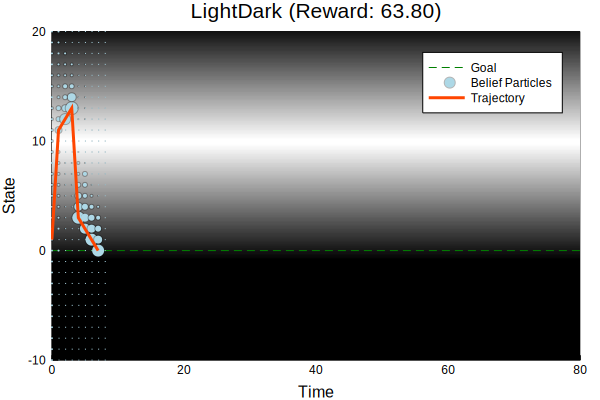

In [11]:
hr = HistoryRecorder(max_steps=80,)
b0 = initial_state_distribution(p)
h = simulate(hr, p, planner, pf, b0, 1)
plothist(p, h)

# Show Tree

In [12]:
using D3Trees
b = initial_state_distribution(p)
a, i = action_info(planner, b)
D3Tree(i[:tree], init_expand=2)

o: <root>
N: 1833      

├──a: -10
│  N: 505     V: -78.1     
│  ├──o: -1.1757796851554918
│  │  N: 62        

│  │  ├──a: -10
│  │  │  N: 9       V: -84.8      (6 children)
│  │  ├──a: -1
│  │  │  N: 30      V: -57.4      (7 children)
│  │  ├──a: 0
│  │  │  N: 6       V: -100       (6 children)
│  │  ├──a: 1
│  │  │  N: 9       V: -85.1      (6 children)
│  │  └──a: 10
│  │     N: 8       V: -88.5      (6 children)
│  ├──o: 9.368276942078516
│  │  N: 65        

│  │  ├──a: -10
│  │  │  N: 11      V: -86.3      (6 children)
│  │  ├──a: -1
│  │  │  N: 19      V: -71.8      (7 children)
│  │  ├──a: 0
│  │  │  N: 7       V: -100       (6 children)
│  │  ├──a: 1
│  │  │  N: 16      V: -77.3      (6 children)
│  │  └──a: 10
│  │     N: 12      V: -82.5      (6 children)
│  ├──o: 9.160081656803088
│  │  N: 64        

│  │  ├──a: -10
│  │  │  N: 14      V: -82.4      (6 children)
│  │  ├──a: -1
│  │  │  N: 12      V: -86.4      (6 children)
│  │  ├──a: 0
│  │  │  N: 8       V: -100       (6 children)
│  │  ├──a: 1
│  │  │  N: 15      V: -81.2      (6 children)
│  │  └──a: 10
│  │     N: 15      V: -81.9      (6 children)
│  ├──o: -65.61568760478482
│  │  N: 64        

│  │  ├──a: -10
│  │  │  N: 11      V: -88.2      (6 children)
│  │  ├──a: -1
│  │  │  N: 15      V: -81.2      (6 children)
│  │  ├──a: 0
│  │  │  N: 8       V: -100       (6 children)
│  │  ├──a: 1
│  │  │  N: 16      V: -77.8      (6 children)
│  │  └──a: 10
│  │     N: 14      V: -81.1      (6 children)
│  ├──o: 1.997771504414784
│  │  N: 66        

│  │  ├──a: -10
│  │  │  N: 10      V: -88.9      (6 children)
│  │  ├──a: -1
│  │  │  N: 18      V: -74.5      (7 children)
│  │  ├──a: 0
│  │  │  N: 8       V: -100       (6 children)
│  │  ├──a: 1
│  │  │  N: 12      V: -86.3      (6 children)
│  │  └──a: 10
│  │     N: 18      V: -75.4      (7 children)
│  ├──o: -5.0269933460930805
│  │  N: 64        

│  │  ├──a: -10
│  │  │  N: 17      V: -73.5      (7 children)
│  │  ├──a: -1
│  │  │  N: 15      V: -75.7      (6 children)
│  │  ├──a: 0
│  │  │  N: 7       V: -100       (6 children)
│  │  ├──a: 1
│  │  │  N: 12      V: -83.2      (6 children)
│  │  └──a: 10
│  │     N: 13      V: -81        (6 children)
│  ├──o: -38.89448763765073
│  │  N: 70        

│  │  ├──a: -10
│  │  │  N: 12      V: -87.7      (6 children)
│  │  ├──a: -1
│  │  │  N: 17      V: -79.4      (7 children)
│  │  ├──a: 0
│  │  │  N: 8       V: -100       (6 children)
│  │  ├──a: 1
│  │  │  N: 14      V: -84.6      (6 children)
│  │  └──a: 10
│  │     N: 19      V: -77.3      (7 children)
│  └──o: 11.16093085645674
│     N: 42        

│     ├──a: -10
│     │  N: 8       V: -83.2      (6 children)
│     ├──a: -1
│     │  N: 9       V: -81.1      (6 children)
│     ├──a: 0
│     │  N: 5       V: -100       (5 children)
│     ├──a: 1
│     │  N: 8       V: -82        (6 children)
│     └──a: 10
│        N: 12      V: -73.9      (6 children)
├──a: -1
│  N: 394     V: -79.5     
│  ├──o: 12.844484478929182
│  │  N: 44        

│  │  ├──a: -10
│  │  │  N: 8       V: -89.3      (6 children)
│  │  ├──a: -1
│  │  │  N: 12      V: -78.4      (6 children)
│  │  ├──a: 0
│  │  │  N: 6       V: -100       (6 children)
│  │  ├──a: 1
│  │  │  N: 8       V: -90.7      (6 children)
│  │  └──a: 10
│  │     N: 10      V: -81.5      (6 children)
│  ├──o: 21.478552054545332
│  │  N: 54        

│  │  ├──a: -10
│  │  │  N: 15      V: -74.2      (6 children)
│  │  ├──a: -1
│  │  │  N: 12      V: -80.3      (6 children)
│  │  ├──a: 0
│  │  │  N: 7       V: -100       (6 children)
│  │  ├──a: 1
│  │  │  N: 10      V: -84.7      (6 children)
│  │  └──a: 10
│  │     N: 10      V: -87.7      (6 children)
│  ├──o: 21.528889791407273
│  │  N: 52        

│  │  ├──a: -10
│  │  │  N: 10      V: -84.3      (6 children)
│  │  ├──a: -1
│  │  │  N: 12      V: -81.1      (6 children)
│  │  ├──a: 0
│  │  │  N: 6       V: -100       (6 children)
│  │  ├──a: 1
│  │  │  N: 14      V: -75.5      (6 children)
│  │  └──a: 10
│  │     N:

In [15]:
using BasicPOMCP
using DiscreteValueIteration
srand(rng, 7)
max_depth = 20
max_time = 0.01
ro = ValueIterationSolver()
sol = POMCPSolver(max_depth=max_depth,
            max_time=max_time,
            c=100.0,
            tree_queries=typemax(Int),
            # estimate_value=FOValue(ro),
            estimate_value=FORollout(RandomSolver()),
            rng=rng,
            tree_in_info=true
           )

planner = solve(sol, p)
b = initial_state_distribution(p)
a, i = action_info(planner, b)
D3Tree(i[:tree])

o: <root>
N: 3232      
├──a: -10
│  N: 574     V: -81.7     
│  ├──o: -9.347729602584621
│  │  N: 0         
│  │  ├──a: -10
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: -1
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 0
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 1
│  │  │  N: 0       V: 0          (0 children)
│  │  └──a: 10
│  │     N: 0       V: 0          (0 children)
│  ├──o: 12.710203827378312
│  │  N: 0         
│  │  ├──a: -10
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: -1
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 0
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 1
│  │  │  N: 0       V: 0          (0 children)
│  │  └──a: 10
│  │     N: 0       V: 0          (0 children)
│  ├──o: 32.06799335291181
│  │  N: 0         
│  │  ├──a: -10
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: -1
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 0
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 1
│  │  │  N: 0       V: 0          (0 children)
│  │  └──a: 10
│  │     N: 0       V: 0          (0 children)
│  ├──o: 17.834709853152525
│  │  N: 0         
│  │  ├──a: -10
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: -1
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 0
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 1
│  │  │  N: 0       V: 0          (0 children)
│  │  └──a: 10
│  │     N: 0       V: 0          (0 children)
│  ├──o: -76.66533112407555
│  │  N: 0         
│  │  ├──a: -10
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: -1
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 0
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 1
│  │  │  N: 0       V: 0          (0 children)
│  │  └──a: 10
│  │     N: 0       V: 0          (0 children)
│  ├──o: -16.17241809436091
│  │  N: 0         
│  │  ├──a: -10
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: -1
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 0
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 1
│  │  │  N: 0       V: 0          (0 children)
│  │  └──a: 10
│  │     N: 0       V: 0          (0 children)
│  ├──o: 12.83958492611209
│  │  N: 0         
│  │  ├──a: -10
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: -1
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 0
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 1
│  │  │  N: 0       V: 0          (0 children)
│  │  └──a: 10
│  │     N: 0       V: 0          (0 children)
│  ├──o: -12.191771055011346
│  │  N: 0         
│  │  ├──a: -10
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: -1
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 0
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 1
│  │  │  N: 0       V: 0          (0 children)
│  │  └──a: 10
│  │     N: 0       V: 0          (0 children)
│  ├──o: -1.7732470707338273
│  │  N: 0         
│  │  ├──a: -10
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: -1
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 0
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 1
│  │  │  N: 0       V: 0          (0 children)
│  │  └──a: 10
│  │     N: 0       V: 0          (0 children)
│  ├──o: -17.132926123132638
│  │  N: 0         
│  │  ├──a: -10
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: -1
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 0
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 1
│  │  │  N: 0       V: 0          (0 children)
│  │  └──a: 10
│  │     N: 0       V: 0          (0 children)
│  ├──o: 6.684889734228321
│  │  N: 0         
│  │  ├──a: -10
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: -1
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 0
│  │  │  N: 0       V: 0          (0 children)
│  │  ├──a: 1
│  │  │  N: 0       V: 0          (0 children)
│  │  └──a: 10
│  │     N: 0       V: 0          (0 children)
│  ├──o: 30